### More geopandas!

- Joining/merging natural earth with emissions data
- Getting shapefiles
- Census API
- US Census Data
- Hopkins COVID-19 Data

In [2]:
#Now load geopandas plus other standard libraries
#####

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import geopandas as gpd

### Recall our Natural Earth choropleth plot

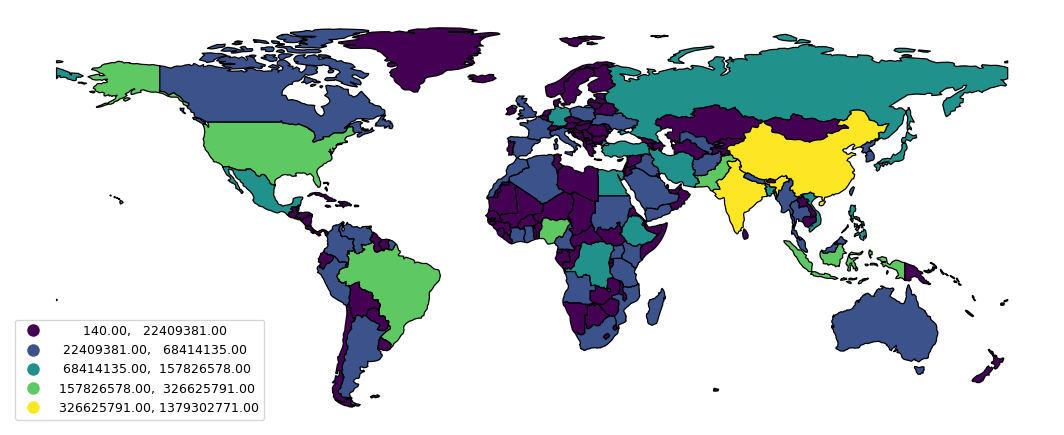

In [10]:
#Load as "gdf"
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#Exclude Antarctica
gdf = gdf.loc[gdf.continent != 'Antarctica']

fig, ax1 = plt.subplots(1,1, figsize=(15, 10), dpi=90)

#Note: scheme + k
#edgecolor: "black", etc. vs. "face"
#missing_kwds, legend, and legend_kwds

gdf.plot(ax=ax1, scheme="fisherjenks", k = 5, column = 'pop_est', linewidth = 1, edgecolor = 'black',
           legend = True, legend_kwds={'loc': 'lower left'})
#          missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"},


#Set some axis stuff
#ax1.get_xaxis().set_ticks([])
#ax1.get_yaxis().set_ticks([])

#Or could just:
ax1.set_axis_off();

### Merge Emissions Data

Let's try to merge the emissions data with the natural earth GeoDataFrame

In [11]:
#Let's redefine here:
def get_carbon_df():
    local_file = r'Data/nation.1751_2017.csv'
    
    name_list = ['Nation', 'Year', 'Total', 'Solid', 'Liquid', 'Gas', 'Cement', 'Flaring', 'Per_Capita', 'Bunker']
    new_df = pd.read_csv(local_file, header = 4, names = name_list, na_values = '. ')
    
    #Throw in stripping the whitespace from the names too:
    new_df.Nation = new_df.Nation.str.strip()
    
    return new_df

In [13]:
df = get_carbon_df()

df.head()

,Nation,Year,Total,Solid,Liquid,Gas,Cement,Flaring,Per_Capita,Bunker
0,AFGHANISTAN,1949,4,4.0,0.0,0.0,0,NaN,NaN,0
1,AFGHANISTAN,1950,23,6.0,18.0,0.0,0,0.0,0.0,0
2,AFGHANISTAN,1951,25,7.0,18.0,0.0,0,0.0,0.0,0
3,AFGHANISTAN,1952,25,9.0,17.0,0.0,0,0.0,0.0,0
4,AFGHANISTAN,1953,29,10.0,18.0,0.0,0,0.0,0.0,0


In [15]:
df = get_carbon_df()

#Let's repeat prior methods: Get the cumulative emissions for each year
########

df_cumulative = df.copy()

#Drop Per_Capita: Doesn't make sense to cumulative sum
df_cumulative.drop(columns = 'Per_Capita', inplace=True)

convert_cols = ['Total', 'Solid', 'Liquid', 'Gas', 'Cement', 'Flaring', 'Bunker']

#Note we preserve the Year, doing this
df_cumulative[convert_cols] = df.groupby(by = ['Nation'])[convert_cols].cumsum()


#just grab the 2017 value:
df_cumulative_2017 = df_cumulative.loc[df_cumulative['Year'] == 2017]

#Note: An alternative syntax: Use the query method
#df_cumulative_2017 = df_cumulative.query('Year == 2017')

df_cumulative_2017.head()

,Nation,Year,Total,Solid,Liquid,Gas,Cement,Flaring,Bunker
68,AFGHANISTAN,2017,43790,11332.0,24874.0,5249.0,709,1625.0,320
153,ALBANIA,2017,74103,17926.0,47119.0,4383.0,4679,0.0,490
261,ALGERIA,2017,1121349,30826.0,391192.0,489710.0,53553,156079.0,30038
289,ANDORRA,2017,3714,0.0,3714.0,0.0,0,0.0,0
357,ANGOLA,2017,173706,437.0,84370.0,9985.0,6613,72307.0,18431


In [17]:
#Now let's try to merge with gdf:
######

#First, let's upper the nation names in both datasets...
df_cumulative_2017.Nation = df_cumulative_2017.Nation.str.upper()

gdf.name = gdf.name.str.upper()


#Now merge: Do a left join (the default is "inner")
carbon_gdf = gdf.merge(df_cumulative_2017, how="left", left_on='name', right_on='Nation')

#Take a quick looksie:
carbon_gdf.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Nation,Year,Total,Solid,Liquid,Gas,Cement,Flaring,Bunker
0,920938,Oceania,FIJI,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FIJI,2017.0,13190.0,515.0,11999.0,1.0,669.0,0.0,5630.0
1,53950935,Africa,TANZANIA,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,603253,Africa,W. SAHARA,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35623680,North America,CANADA,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CANADA,2017.0,8504907.0,2549524.0,3764990.0,2024843.0,97505.0,68036.0,114343.0
4,326625791,North America,UNITED STATES OF AMERICA,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",UNITED STATES OF AMERICA,2017.0,106580008.0,46225736.0,40114766.0,19227174.0,712535.0,299800.0,1675645.0


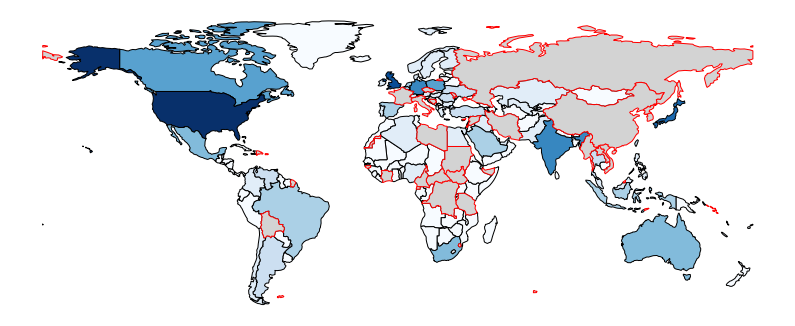

In [19]:
#Now let's see what we ended up with...
#Plot by Total cumulative emissions

fig, ax1 = plt.subplots(1,1, figsize=(14, 8))

carbon_gdf.plot(ax = ax1, column = 'Total', scheme="fisherjenks", k=10, cmap='Blues', edgecolor='black',
           missing_kwds={"color": "lightgrey", "edgecolor": "red", "label": "Missing values"})
           #legend = True, legend_kwds={'loc': 'lower left'})
    
ax1.set_axis_off()

#### How to fill in missing countries?

Manually...

Let's export our current mapping of `Nation` in the emissions data to `iso_a3`, and then we'll fill in the countries with NaNs

Let's add the additional caveat that we only want countries with non-zero/non-NaN emissions in 2017

In [20]:
###Get all countries with emissions in 2017, and merge with the natural earth gdf:
df = get_carbon_df()
df = df.loc[df['Total'].notnull() & (df['Year'] == 2017)]

#Upper the names
df.Nation = df.Nation.str.upper()
gdf.name = gdf.name.str.upper()

#We don't need geometry now, let's drop and convert to a regular DataFrame:
carbon_df = gdf.drop(columns = ['geometry'])
carbon_df = pd.DataFrame(carbon_df)

#Now merge: This time do an outer join!
carbon_df = carbon_df.merge(df, how="outer", left_on='name', right_on='Nation')


#And now let's write our variables of interest to a csv file:
#Note: We don't write the index
carbon_df[['name', 'Nation', 'iso_a3']].to_csv('carbon_name_map_2.csv', index=False)


In [31]:
#Note that the natural earth dataset had a few missing iso codes as well:
display(gdf.loc[gdf.iso_a3 == '-99'])

#Let's fix France and Norway:

gdf.iso_a3.loc[gdf.name == 'FRANCE'] = 'FRA'
gdf.iso_a3.loc[gdf.name == 'NORWAY'] = 'NOR'

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,NORWAY,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
43,67106161,Europe,FRANCE,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
160,265100,Asia,N. CYPRUS,-99,3600.0,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
167,3500000,Africa,SOMALILAND,-99,12250.0,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
174,1895250,Europe,KOSOVO,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


C:\Users\steff\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [33]:
#After fixing everything up, we re-load:

iso_map = pd.read_csv('carbon_name_map_filled.csv')

#Merge with df: Do an inner join: Only keep stuff with a Nation (and hopefully have an iso code now)
df_iso = df.merge(iso_map[['Nation', 'iso_a3']], how="inner", on="Nation")

df_iso

,Nation,Year,Total,Solid,Liquid,Gas,Cement,Flaring,Per_Capita,Bunker,iso_a3
0,AFGHANISTAN,2017,1879,941.0,837.0,82.0,19,0.0,0.05,9,AFG
1,ALBANIA,2017,1475,120.0,1119.0,23.0,213,0.0,0.51,31,ALB
2,ALGERIA,2017,42246,217.0,15113.0,22476.0,2865,1575.0,1.02,505,DZA
3,ANDORRA,2017,127,0.0,127.0,0.0,0,0.0,1.65,0,NaN
4,ANGOLA,2017,10231,0.0,5493.0,429.0,533,3776.0,0.34,549,AGO
...,...,...,...,...,...,...,...,...,...,...,...
213,VIET NAM,2017,50156,21201.0,15545.0,4879.0,8531,0.0,0.53,918,VNM
214,WALLIS AND FUTUNA ISLANDS,2017,7,0.0,7.0,0.0,0,0.0,0.56,1,NaN
215,YEMEN,2017,2729,92.0,2115.0,323.0,199,0.0,0.10,96,YEM
216,ZAMBIA,2017,1718,519.0,975.0,0.0,224,0.0,0.10,22,ZMB


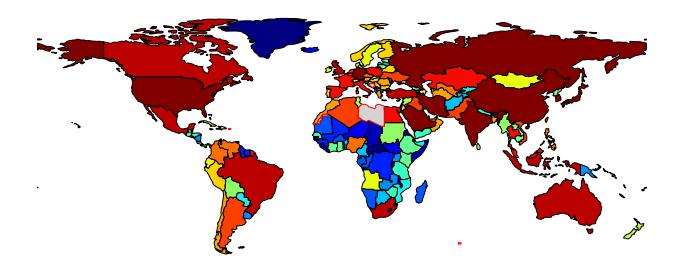

In [42]:
#Now join with the gdf, now using our new iso_a3 codes
###############
#Getting 2017 emissions:
carbon_gdf_2017 = gdf.merge(df_iso, how="left", on='iso_a3')


#And plot...
fig, ax1 = plt.subplots(1,1, figsize=(12, 8))

carbon_gdf_2017.plot(ax = ax1, column = 'Total', scheme="quantiles", k=20, cmap='jet', edgecolor='black',
           missing_kwds={"color": "lightgrey", "edgecolor": "red", "label": "Missing values"})
    
ax1.set_axis_off()

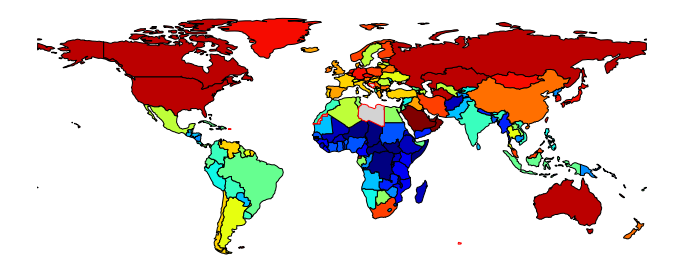

In [40]:
#Do per capita:
#######
fig, ax1 = plt.subplots(1,1, figsize=(12, 8))

carbon_gdf_2017.plot(ax = ax1, column = carbon_gdf_2017.Total / carbon_gdf_2017.pop_est,
           scheme="quantiles", k=20, cmap='jet', edgecolor='black',
           missing_kwds={"color": "lightgrey", "edgecolor": "red", "label": "Missing values"})
    
ax1.set_axis_off()


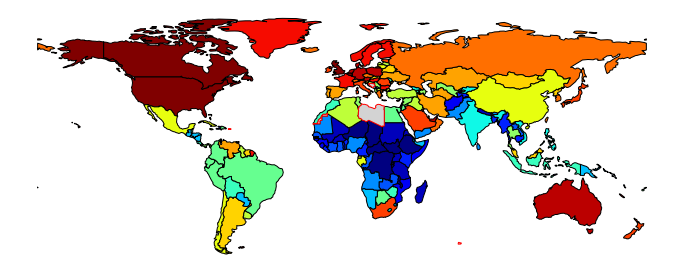

In [45]:
#Finally, let's look at cumulative emissions
#####

#Still have df_cumulative_2017 from above:
#Merge with our iso codes:
df_cumulative_2017_iso = df_cumulative_2017.merge(iso_map[['Nation', 'iso_a3']], how="inner", on="Nation")

#And now merge with the gdf:
carbon_cumulative_gdf_2017 = gdf.merge(df_cumulative_2017_iso, how="left", on='iso_a3')


fig, ax1 = plt.subplots(1,1, figsize=(12, 8))

#Do cumulative emission per capita based on 2017 population
#Need to take historical population/emissions into account for this to really be valid?
carbon_cumulative_gdf_2017.plot(ax = ax1, column = carbon_cumulative_gdf_2017.Total / carbon_cumulative_gdf_2017.pop_est,
           scheme="quantiles", k=20, cmap='jet', edgecolor='black',
           missing_kwds={"color": "lightgrey", "edgecolor": "red", "label": "Missing values"})
    
ax1.set_axis_off()

Use applymap for some custom stuff...

<AxesSubplot:>

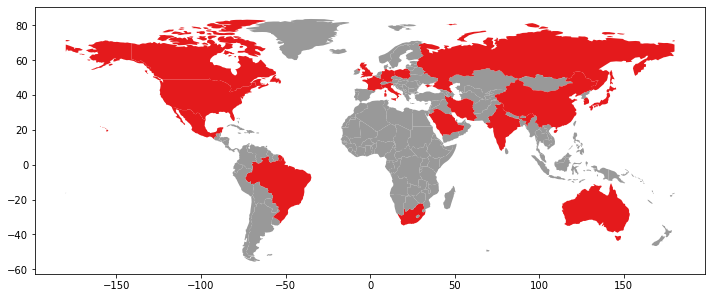

In [46]:
#Let's see everywhere cumulative emissions exceeded some percentile
####

gdf2 = carbon_cumulative_gdf_2017.copy()

#Define our lambda function:
f = lambda x, thresh, var: 1 if x >= np.percentile(var, thresh) else 0

#Use applymap:
gdf2['Exceeds'] = gdf2[['Total']].applymap(f, var = gdf2['Total'].dropna(), thresh = 90)

gdf2.plot(column = 'Exceeds', cmap='Set1_r', figsize=(12,10))


In [47]:
carbon_cumulative_gdf_2017.sort_values(by='Total', ascending=False)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Nation,Year,Total,Solid,Liquid,Gas,Cement,Flaring,Bunker
4,326625791,North America,UNITED STATES OF AMERICA,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",UNITED STATES OF AMERICA,2017.0,106580008.0,46225736.0,40114766.0,19227174.0,712535.0,299800.0,1675645.0
139,1379302771,Asia,CHINA,CHN,21140000.0,"MULTIPOLYGON (((109.47521 18.19770, 108.65521 ...",CHINA (MAINLAND),2017.0,54457915.0,42327190.0,7651261.0,1207374.0,3263736.0,8355.0,191076.0
143,64769452,Europe,UNITED KINGDOM,GBR,2788000.0,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",UNITED KINGDOM,2017.0,20811590.0,15436727.0,3456718.0,1727271.0,135539.0,55331.0,493008.0
155,126451398,Asia,JAPAN,JPN,4932000.0,"MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...",JAPAN,2017.0,15608275.0,4978876.0,8563018.0,1543446.0,522576.0,364.0,558742.0
121,80594017,Europe,GERMANY,DEU,3979000.0,"POLYGON ((14.11969 53.75703, 14.35332 53.24817...",GERMANY,2017.0,13335524.0,9799003.0,2213018.0,1196820.0,119537.0,7143.0,210808.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,603253,Africa,W. SAHARA,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,140,Seven seas (open ocean),FR. S. ANTARCTIC LANDS,ATF,16.0,"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,3351827,North America,PUERTO RICO,PRI,131000.0,"POLYGON ((-66.28243 18.51476, -65.77130 18.426...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,6653210,Africa,LIBYA,LBY,90890.0,"POLYGON ((25.00000 22.00000, 25.00000 20.00304...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Depict using centroids

We can make a bubble plot to represent emissions using centroids...

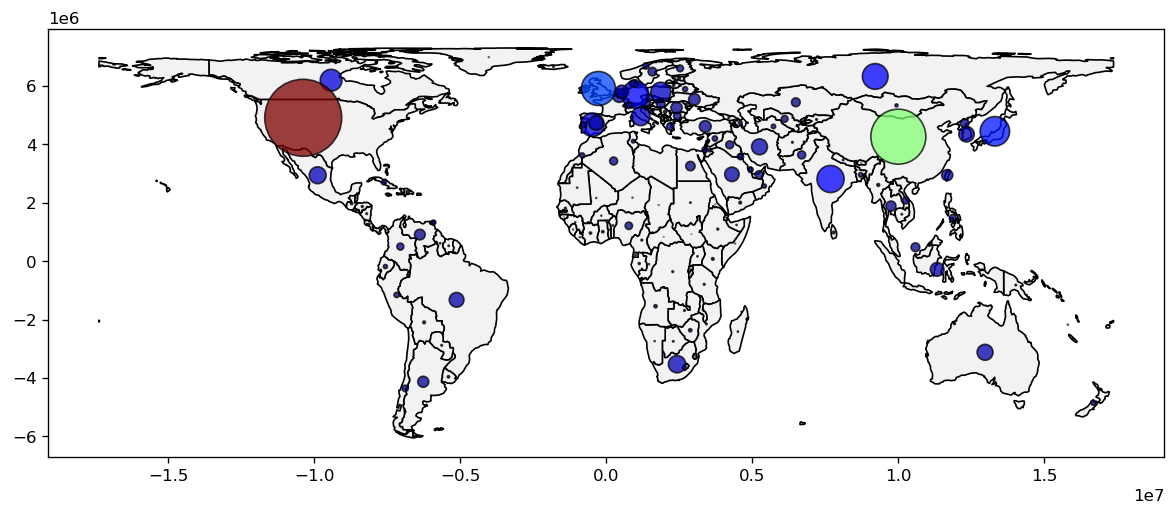

In [52]:
carbon_cumulative_gdf_2017 = carbon_cumulative_gdf_2017.to_crs(epsg = 6933)

carbon_cumulative_gdf_2017['centroid_column'] = carbon_cumulative_gdf_2017.centroid

#We can set geometry:
gdf2 = carbon_cumulative_gdf_2017.set_geometry('centroid_column')

fig, ax1 = plt.subplots(1,1, figsize=(12, 8), dpi=120)


#Need to drop NA: markersize and column handle NaNs differently!

gdf2 = gdf2.dropna()

carbon_cumulative_gdf_2017.plot(ax = ax1, edgecolor='black', facecolor=(.95, .95, .95))
gdf2.plot(ax = ax1, markersize = gdf2.Total/5e4, column = gdf2.Total, alpha = .75,
                edgecolor = 'black', cmap='jet');


#### Note the geoplot library

We can do some other visualizationw with the `geoplot` library. For example, a *cartogram*:

In [53]:
#Install geoplot first...

import geoplot

C:\Users\steff\Anaconda3\envs\geo_env\lib\site-packages\geoplot\geoplot.py:1267: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in scaled_polygon:
C:\Users\steff\Anaconda3\envs\geo_env\lib\site-packages\geoplot\geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

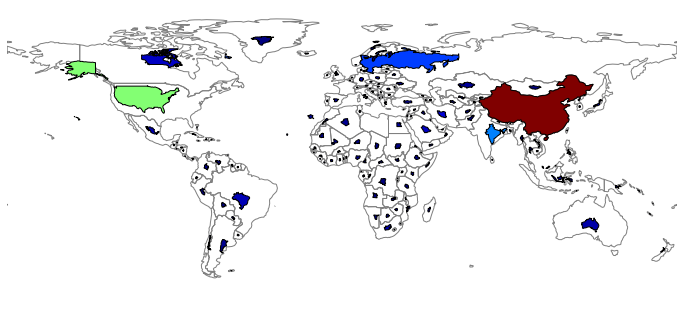

In [56]:
#Make the cartogram:
######

#Note the .dropna() method:
ax1 = geoplot.cartogram(
    carbon_gdf_2017.dropna(), scale=carbon_gdf_2017.Total,
    edgecolor='black', linewidth = 1, hue='Total', cmap = 'jet', figsize=(12, 8))

geoplot.polyplot(gdf, edgecolor='gray', ax = ax1)


#### (Can also see the cartopy library)

### Census Shapefiles

- Recall the ESRI shapefile (shp):
- Multiple files
- Best to put in single folder
- Variable names limited to 10 characters
- Can load directly from url with geopandas...

In [57]:
#Get high-res shapefile data directly from census URLs
#########

#Load the states
url_states = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'

state_gdf = gpd.read_file(url_states)

display(state_gdf.head())

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


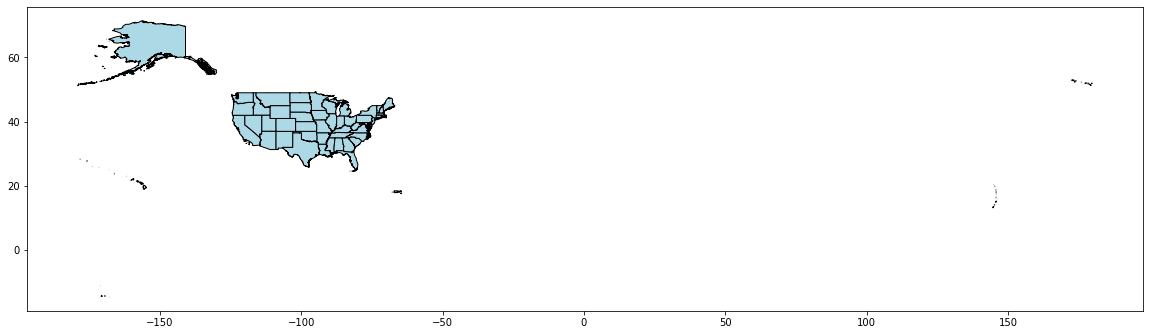

In [58]:
#And Plot
fig, my_ax = plt.subplots(1,1, figsize=(20, 10))

state_gdf.plot(ax = my_ax, linewidth = 1, edgecolor = 'black', facecolor='lightblue');

(51.0, 54.0)

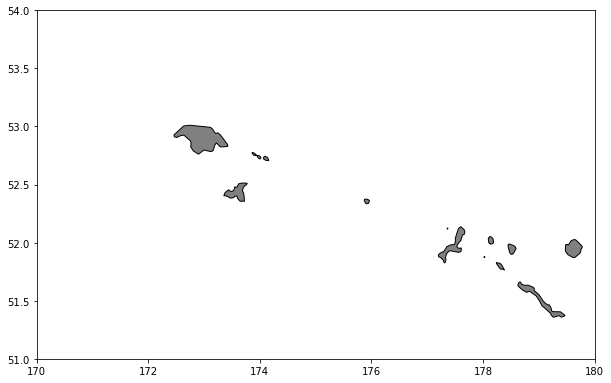

In [59]:
#Let's zoom in on the "Near Islands" and the "Rat Islands"
fig, my_ax = plt.subplots(1,1, figsize=(10, 8))

state_gdf.loc[state_gdf.STATEFP == '02'].plot(ax = my_ax, edgecolor = 'black', facecolor='grey')

#Set our limits:
my_ax.set_xlim([170, 180])
my_ax.set_ylim([51, 54])


#### Note the CRS:

In [60]:
state_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

#### Consider the (North American) Albers Equal Area Conic

- Projection cone
- Choose 2 standard parallels to intersect sphere
- Distortion minimized between parallels
- Project onto cone from inside sphere
- N. American Albers standard for US Government (+NAD83 datum)

<img src="albers_fig.png" width=650 />

<img src="albers_fig2.png" width=450 />


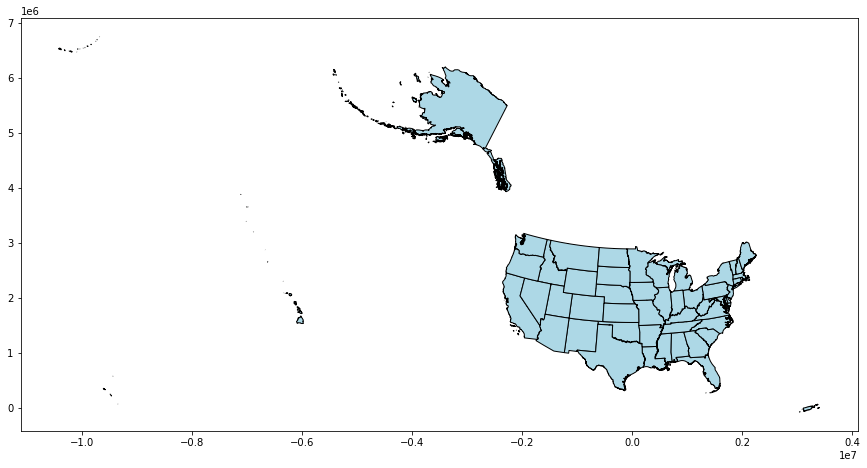

In [61]:
#Convert crs again:
#####
state_gdf = state_gdf.to_crs(5070)


#And Plot again:
fig, my_ax = plt.subplots(1,1, figsize=(15, 10))

state_gdf.plot(ax = my_ax, linewidth = 1, edgecolor = 'black', facecolor='lightblue');


<AxesSubplot:>

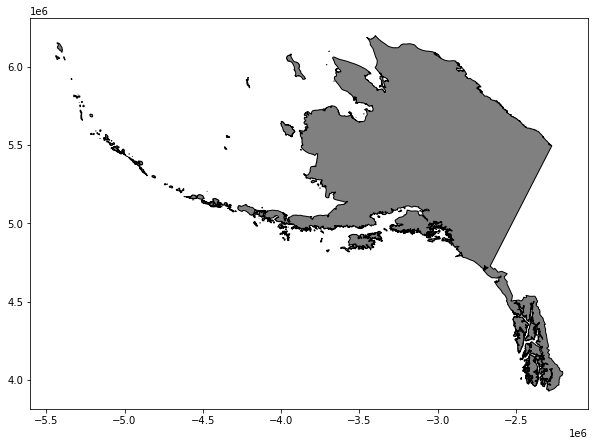

In [62]:
#And Alaska:
fig, my_ax = plt.subplots(1,1, figsize=(10, 8))

state_gdf.loc[state_gdf.STATEFP == '02'].plot(ax = my_ax, edgecolor = 'black', facecolor='grey')

<AxesSubplot:>

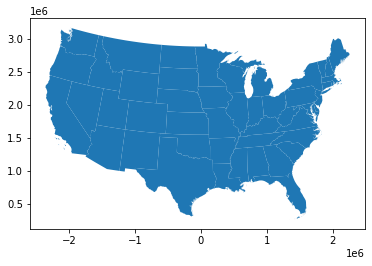

In [63]:
#Now let's just plot the lower 48
#Follow same method as with sf objects in R:

#Hawaii = 15, Alasks = 02, Puerto Rico = 72
#Guam = 66, Northern Mariana Islands = 69, American Samoa = 60, Virgin Islands = 78
#Washington DC = 11

#Note the astype('int') method:
#state_gdf = state_gdf.loc[(state_gdf.STATEFP.astype(int) != 15) & 
#                           (state_gdf.STATEFP.astype(int) != 72) &
#                           (state_gdf.STATEFP.astype(int) != 2) &
#                           (state_gdf.STATEFP.astype(int) != 60) &
#                           (state_gdf.STATEFP.astype(int) != 66) &
#                           (state_gdf.STATEFP.astype(int) != 69) &
#                           (state_gdf.STATEFP.astype(int) != 78)]

#Or, more compactly:
exclude_list = [15, 72, 2, 60, 66, 69, 78]

#~ is not
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]

state_gdf.plot()

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

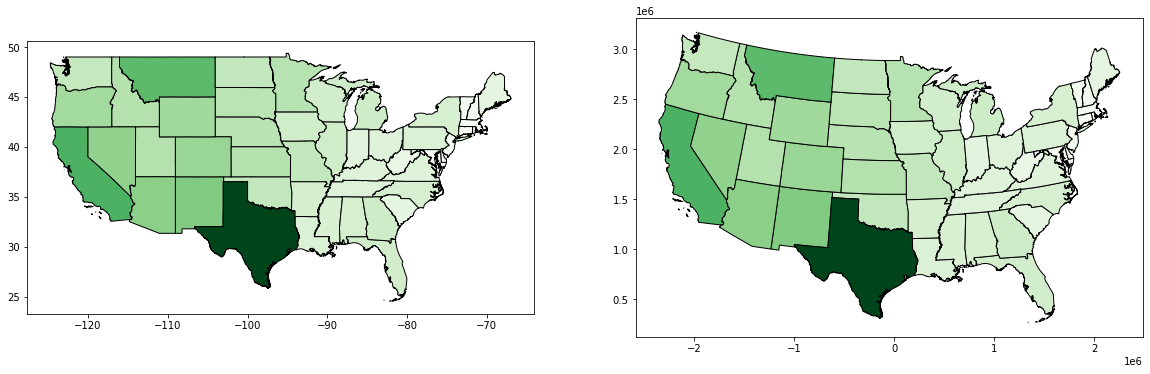

In [64]:
#Plot using both EPSG 4269 and 5070:

fig, ax1 = plt.subplots(1,2, figsize=(20, 10))

state_gdf = state_gdf.to_crs(epsg=4269)
state_gdf.plot(ax = ax1[0], edgecolor = 'black', column='ALAND', cmap='Greens');
display(state_gdf.crs)


state_gdf = state_gdf.to_crs(epsg=5070)
state_gdf.plot(ax = ax1[1], edgecolor = 'black', column='ALAND', cmap='Greens');
display(state_gdf.crs)

### Do the same thing for counties...

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


<AxesSubplot:>

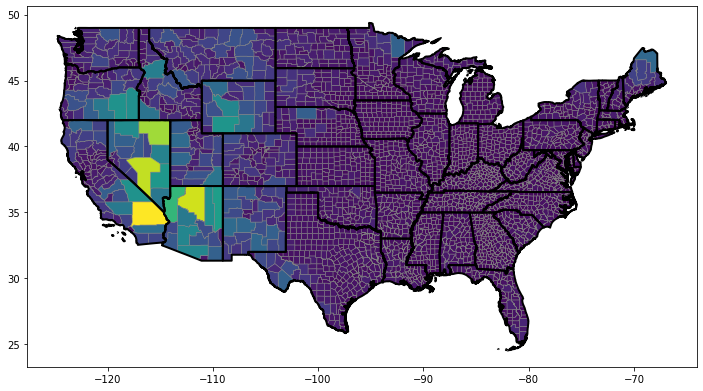

In [65]:
#Get shapefile data directly from census URLs: Just do both counties and states here
#########

#Load the counties
url_county = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip'
url_state = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'

county_gdf = gpd.read_file(url_county)
state_gdf = gpd.read_file(url_state)


#Exclude everthing outside the contiguous US:
exclude_list = [15, 72, 2, 60, 66, 69, 78]
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]

county_gdf = county_gdf.loc[~county_gdf['STATEFP'].astype(int).isin(exclude_list)]


display(county_gdf.head())

fig, my_ax = plt.subplots(1,1, figsize=(12, 8))

county_gdf.plot(ax = my_ax, linewidth = .5, edgecolor = 'grey', column = 'ALAND')
state_gdf.plot(ax = my_ax, linewidth = 2, edgecolor = 'black', facecolor = 'none')


In [219]:
#Note the county_gdf structure:
display(county_gdf.head())

county_gdf.dtypes

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


STATEFP       object
COUNTYFP      object
COUNTYNS      object
AFFGEOID      object
GEOID         object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
geometry    geometry
dtype: object

**FIPS**

Note that each county has a `STATEFP` and a `COUNTYFP`.  We can concatenate these into a single FIPS, to uniquely identify each county.

<AxesSubplot:>

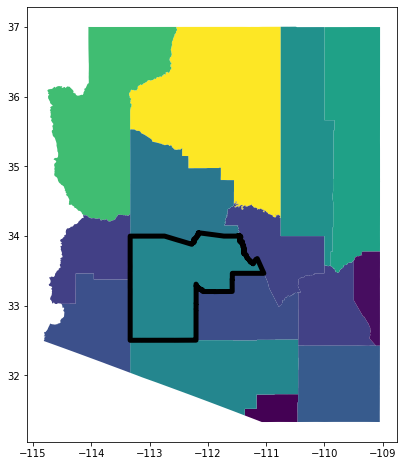

In [66]:
#We can make a single FIPS like so: Concatenate strings:
county_gdf['FIPS'] = county_gdf.STATEFP + county_gdf.COUNTYFP

#Example: Arizona:
#display(county_gdf.loc[county_gdf.STATEFP == '04'].head(20))

fig, ax1 = plt.subplots(1,1, figsize=(12, 8))

#Show Arizona, Highlight Maricopa:
county_gdf.loc[county_gdf.STATEFP == '04'].plot(ax = ax1, column = 'ALAND')
county_gdf.loc[county_gdf.FIPS == '04013'].plot(ax = ax1, linewidth = 5, edgecolor = 'black', facecolor='none')

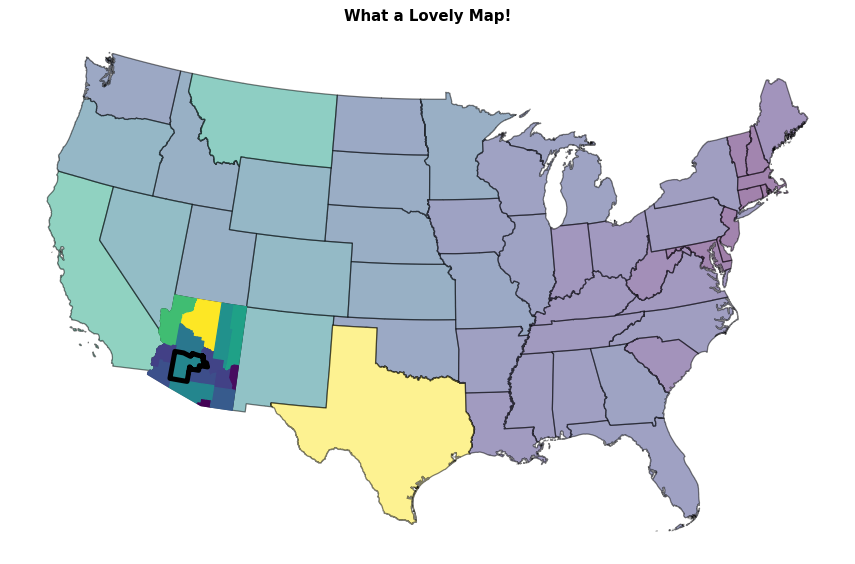

In [67]:
#Can put multiple plots together:
####

#Let's change the CRS first:
state_gdf.to_crs(epsg=5070, inplace=True)
county_gdf.to_crs(epsg=5070, inplace=True)


fig, ax1 = plt.subplots(1,1, figsize=(12, 8), dpi=90)

state_gdf.plot(ax = ax1, edgecolor = 'black', column = 'ALAND', alpha=.5)
county_gdf.loc[county_gdf.STATEFP == '04'].plot(ax = ax1, column = 'ALAND', edgecolor='face')
county_gdf.loc[county_gdf.FIPS == '04013'].plot(ax = ax1, linewidth = 4, edgecolor = 'black', facecolor='none')

ax1.set_axis_off()
ax1.set_title('What a Lovely Map!', fontweight='bold');

### Merging Demographic, etc. data

**Census API**

We can use the `census` package to access the Census Data API. With this, we can get county-level population data and merge with our county geometries (woo!). Install this package, and then follow the code below to get 2019 population estimates.

- **You will need to get an API Key from https://api.census.gov/data/key_signup.html (this should only take a minute). Insert your personal key into the code below...**

- We will get data from: American Community Survey 5-Year Data (2009-2019), at https://www.census.gov/data/developers/data-sets/acs-5year.html

- You can also use the advanced search at the US Census Data website to access this data and download locally.

In [68]:
#Install and load census library
from census import Census

In [69]:
#Example of getting 2019 county-level population:
#Insert your key here:
c = Census("<YOUR KEY HERE")
pop = c.acs5.get(('NAME', 'B01001_001E'),
          {'for': 'county:*'}, year=2019)


#Let's see what we got:
#List of dictionaries
pop

[{'NAME': 'Fayette County, Illinois',
  'B01001_001E': 21565.0,
  'state': '17',
  'county': '051'},
 {'NAME': 'Logan County, Illinois',
  'B01001_001E': 29003.0,
  'state': '17',
  'county': '107'},
 {'NAME': 'Saline County, Illinois',
  'B01001_001E': 23994.0,
  'state': '17',
  'county': '165'},
 {'NAME': 'Lake County, Illinois',
  'B01001_001E': 701473.0,
  'state': '17',
  'county': '097'},
 {'NAME': 'Massac County, Illinois',
  'B01001_001E': 14219.0,
  'state': '17',
  'county': '127'},
 {'NAME': 'Cass County, Illinois',
  'B01001_001E': 12493.0,
  'state': '17',
  'county': '017'},
 {'NAME': 'Huntington County, Indiana',
  'B01001_001E': 36359.0,
  'state': '18',
  'county': '069'},
 {'NAME': 'White County, Indiana',
  'B01001_001E': 24149.0,
  'state': '18',
  'county': '181'},
 {'NAME': 'Jay County, Indiana',
  'B01001_001E': 20840.0,
  'state': '18',
  'county': '075'},
 {'NAME': 'Shelby County, Indiana',
  'B01001_001E': 44438.0,
  'state': '18',
  'county': '145'},
 {'NAME

In [70]:
#We can easily convert to a DataFrame:
########

df_county = pd.DataFrame(pop, columns=['NAME', 'B01001_001E', 'state', 'county'])

#And let's rename B01001_001E:
df_county = df_county.rename(columns={"B01001_001E": "POP"})

df_county

,NAME,POP,state,county
0,"Fayette County, Illinois",21565.0,17,051
1,"Logan County, Illinois",29003.0,17,107
2,"Saline County, Illinois",23994.0,17,165
3,"Lake County, Illinois",701473.0,17,097
4,"Massac County, Illinois",14219.0,17,127
...,...,...,...,...
3215,"Crockett County, Tennessee",14399.0,47,033
3216,"Lake County, Tennessee",7401.0,47,095
3217,"Knox County, Tennessee",461104.0,47,093
3218,"Benton County, Washington",197518.0,53,005


In [71]:
#Note, can always do standard pandas stuff first:
####

df_county.describe()

,POP
count,3.220000e+03
mean,1.018684e+05
std,3.273446e+05
min,6.600000e+01
25%,1.119375e+04
50%,2.594600e+04
75%,6.672375e+04
max,1.008157e+07


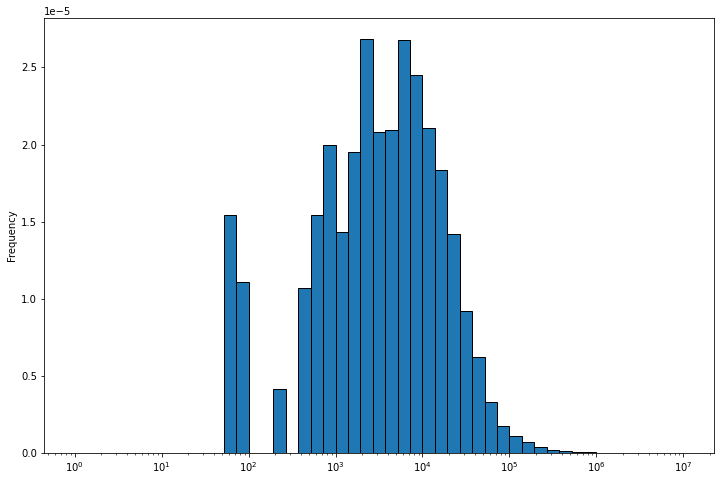

In [72]:
#Look at distribution:
#Plot on a log scale for the x axis
fig1, ax1 = plt.subplots(1,1, figsize=(12, 8))

#Note we need to define our own breaks on a log scale:
bin_breaks = np.logspace(0, 7, 50)
df_county['POP'].plot.hist(ax = ax1, linewidth=1, edgecolor='black', bins=bin_breaks, density=True)

ax1.set_xscale('log');


In [73]:
#Some extremely small outliers:
df_county.sort_values(by = 'POP')


,NAME,POP,state,county
163,"Kalawao County, Hawaii",66.0,15,005
1530,"Loving County, Texas",98.0,48,301
522,"King County, Texas",237.0,48,269
2825,"McPherson County, Nebraska",395.0,31,117
1797,"Arthur County, Nebraska",427.0,31,005
...,...,...,...,...
204,"San Diego County, California",3316073.0,06,073
1197,"Maricopa County, Arizona",4328810.0,04,013
2770,"Harris County, Texas",4646630.0,48,201
708,"Cook County, Illinois",5198275.0,17,031


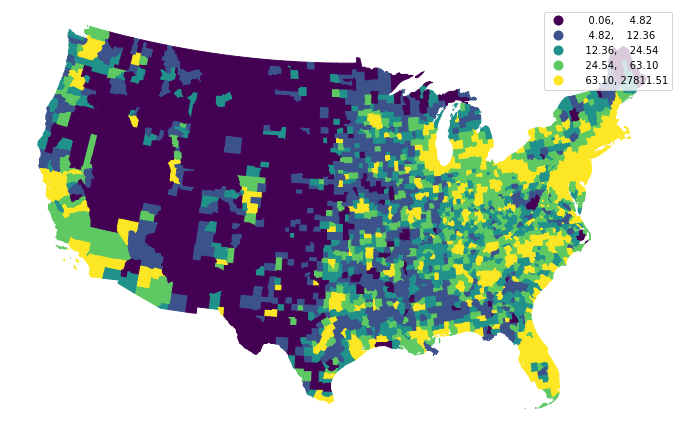

In [78]:
#Now lets create a FIPS variable, merge with geometry, and plot!

df_county['FIPS'] = df_county.state + df_county.county

#Merge
gdf = county_gdf.merge(df_county[['FIPS', 'POP']], left_on='FIPS', right_on='FIPS', how='left')

fig1, ax1 = plt.subplots(1,1, figsize=(12, 8))

#Plot:
#gdf.plot(ax=ax1, column=gdf.POP, edgecolor='face', scheme='quantiles', legend=True)

#Or pop density:
#gdf.plot(ax=ax1, column=gdf.POP  / gdf.ALAND * 1e6, edgecolor='face', scheme='quantiles', legend=True)
ax1.set_axis_off()

Text(0, 0.5, 'Population or Population Density')

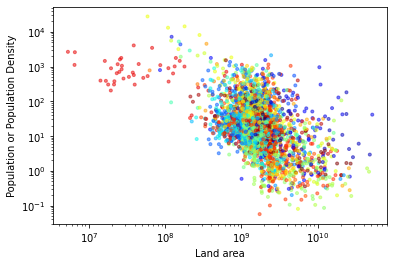

In [83]:
#Quick Question: Does *county* land area correlate with population? Population density?

#let's do on a log-log scale:

#plt.scatter(x = gdf.ALAND, y = gdf.POP, alpha=.5, color='blue', marker='.')
plt.scatter(x = gdf.ALAND, y = gdf.POP / gdf.ALAND * 1e6, alpha=.5, marker='.', c = gdf.STATEFP.astype(int), cmap='jet')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Land area')
plt.ylabel('Population or Population Density')

### Lab 3 Dataset

We can load and merge the same Census dataset we used in Lab 3...Except this time, let's use ***county-level*** data

In [84]:
#Here's our URL:
url_name = r'https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020-alldata.csv'

#Note the encoding:
df = pd.read_csv(url_name, encoding = "ISO-8859-1", engine='python')

df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019,RNETMIG2020
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,0.680010,1.282825,1.614391,0.653828,0.730419,0.854384,1.197150,1.966095,2.677866,3.091308
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,6.236931,-5.971016,-3.773344,2.206640,-1.529706,4.954403,0.993228,-0.018021,3.486011,6.290545
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,16.705437,17.670696,22.924288,20.300088,17.902273,21.436499,22.476720,24.846335,25.242507,26.401562
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,0.329254,-6.860371,-8.093425,-5.063857,-15.677998,-18.377839,-25.138734,-8.790155,-6.257064,0.649799
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,-4.912927,-3.789130,-5.800695,1.420612,1.286202,-0.841769,-3.235672,-7.271592,0.268980,-7.199262


In [86]:
#Let's merge with the gdf_county:
#Let's first note our relevant columns:
display(county_gdf.columns)
display(df.columns)

#display(df.dtypes)

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'FIPS'],
      dtype='object')

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'CENSUS2010POP', 'ESTIMATESBASE2010', 'POPESTIMATE2010',
       ...
       'RNETMIG2011', 'RNETMIG2012', 'RNETMIG2013', 'RNETMIG2014',
       'RNETMIG2015', 'RNETMIG2016', 'RNETMIG2017', 'RNETMIG2018',
       'RNETMIG2019', 'RNETMIG2020'],
      dtype='object', length=180)

In [87]:
#Let's construct a FIPS for df, using zfill:
#This will give us a leading 0:
df.COUNTY.astype(str).str.zfill(3)


0       000
1       001
2       003
3       005
4       007
       ... 
3189    037
3190    039
3191    041
3192    043
3193    045
Name: COUNTY, Length: 3194, dtype: object

In [88]:
#Make FIPS:

df['FIPS'] = df.STATE.astype(str).str.zfill(2) + df.COUNTY.astype(str).str.zfill(3)

gdf_county_all = county_gdf.merge(df, left_on='FIPS', right_on='FIPS', how='left')


In [227]:
#List all the columns:
list(gdf_county_all.columns)

['STATEFP',
 'COUNTYFP',
 'COUNTYNS',
 'AFFGEOID',
 'GEOID',
 'NAME',
 'LSAD',
 'ALAND',
 'AWATER',
 'geometry',
 'FIPS',
 'SUMLEV',
 'REGION',
 'DIVISION',
 'STATE',
 'COUNTY',
 'STNAME',
 'CTYNAME',
 'CENSUS2010POP',
 'ESTIMATESBASE2010',
 'POPESTIMATE2010',
 'POPESTIMATE2011',
 'POPESTIMATE2012',
 'POPESTIMATE2013',
 'POPESTIMATE2014',
 'POPESTIMATE2015',
 'POPESTIMATE2016',
 'POPESTIMATE2017',
 'POPESTIMATE2018',
 'POPESTIMATE2019',
 'POPESTIMATE2020',
 'NPOPCHG_2010',
 'NPOPCHG_2011',
 'NPOPCHG_2012',
 'NPOPCHG_2013',
 'NPOPCHG_2014',
 'NPOPCHG_2015',
 'NPOPCHG_2016',
 'NPOPCHG_2017',
 'NPOPCHG_2018',
 'NPOPCHG_2019',
 'NPOPCHG_2020',
 'BIRTHS2010',
 'BIRTHS2011',
 'BIRTHS2012',
 'BIRTHS2013',
 'BIRTHS2014',
 'BIRTHS2015',
 'BIRTHS2016',
 'BIRTHS2017',
 'BIRTHS2018',
 'BIRTHS2019',
 'BIRTHS2020',
 'DEATHS2010',
 'DEATHS2011',
 'DEATHS2012',
 'DEATHS2013',
 'DEATHS2014',
 'DEATHS2015',
 'DEATHS2016',
 'DEATHS2017',
 'DEATHS2018',
 'DEATHS2019',
 'DEATHS2020',
 'NATURALINC2010',
 'N

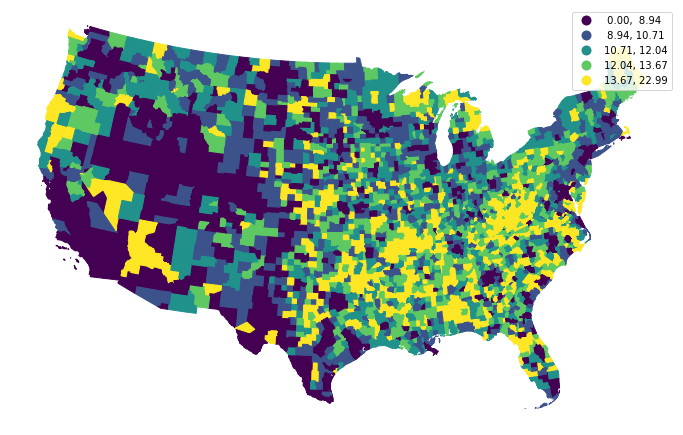

In [90]:
#And Some Fine Plotting:
fig1, ax1 = plt.subplots(1,1, figsize=(12, 8))

gdf_county_all.plot(ax=ax1, column='RDEATH2020', edgecolor='face', scheme='quantiles', legend=True)

ax1.set_axis_off()

### COVID-19 Data in Brief

In [92]:
#Get Cumulative cases/Deaths until 11/14/2021
covid_url = r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/04-10-2022.csv'

covid_df = pd.read_csv(covid_url)

covid_df.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,Total_Test_Results,People_Hospitalized,Case_Fatality_Ratio,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2022-04-11 04:35:00,32.3182,-86.9023,1296730,19376,NaN,NaN,1.0,26446.687204,7497533.0,NaN,1.494220,84000001.0,USA,152911.485086,NaN
1,Alaska,US,2022-04-11 04:35:00,61.3707,-152.4044,248675,1228,NaN,NaN,2.0,33993.124141,NaN,NaN,0.493817,84000002.0,USA,NaN,NaN
2,American Samoa,US,2022-04-11 04:35:00,-14.2710,-170.1320,5018,8,NaN,NaN,60.0,9018.529502,NaN,NaN,0.159426,16.0,ASM,NaN,NaN
3,Arizona,US,2022-04-11 04:35:00,33.7298,-111.4312,2014020,29681,NaN,NaN,4.0,27669.986345,18995536.0,NaN,1.473719,84000004.0,USA,260973.685335,NaN
4,Arkansas,US,2022-04-11 04:35:00,34.9697,-92.3731,833685,11308,NaN,NaN,5.0,27625.551560,5085919.0,NaN,1.356388,84000005.0,USA,168530.461223,NaN


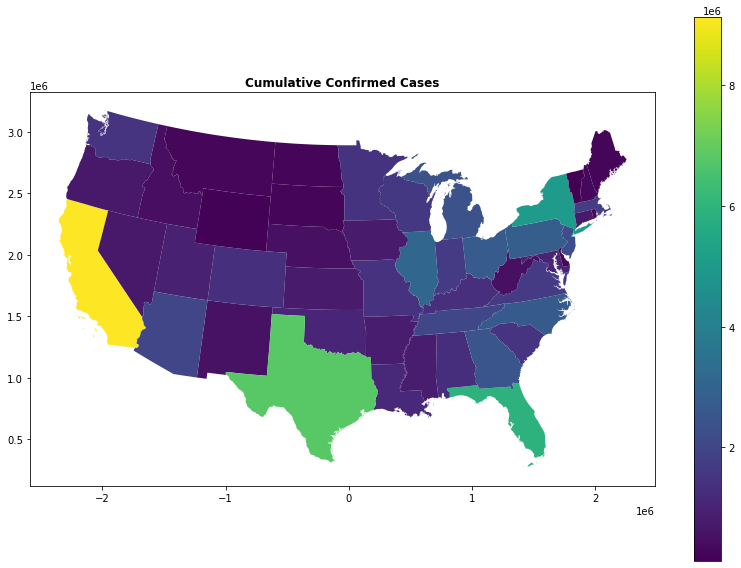

In [96]:
#Merge as usual...
covid_state_gdf = state_gdf.merge(covid_df, left_on = 'NAME', right_on = 'Province_State', how='left')

#And plot, as usual:
fig, ax1 = plt.subplots(1,1, figsize=(14, 10))

covid_state_gdf.plot(ax=ax1, column='Confirmed', legend=True)
ax1.set_title('Cumulative Confirmed Cases', fontweight='bold');


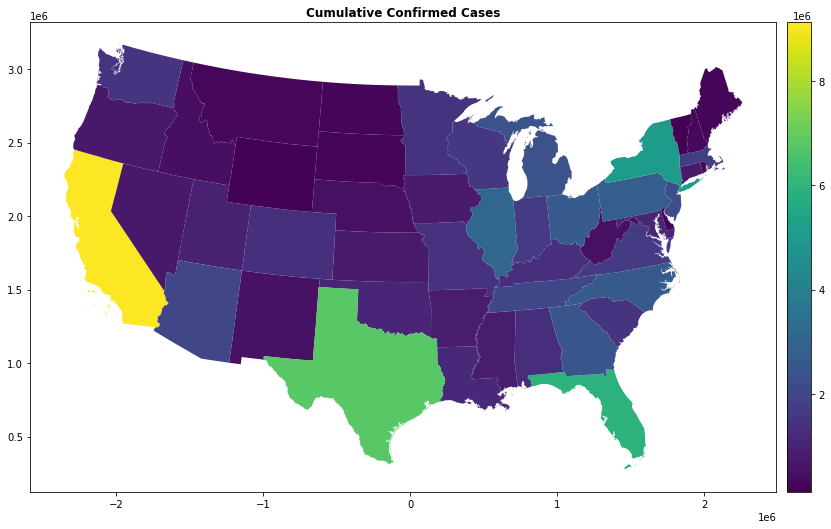

In [97]:
#To pretty up the colorbar:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax1 = plt.subplots(1,1, figsize=(14, 10))

#Pretty up the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3.25%", pad=0.15)

covid_state_gdf.plot(ax=ax1, column='Confirmed', legend=True, cax=cax)
ax1.set_title('Cumulative Confirmed Cases', fontweight='bold');
